In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import json
import string
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.utils import tokenize

from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import (
    strip_non_alphanum,
    split_alphanum,
    strip_short,
    strip_numeric
)

from gensim.models.ldamodel import LdaModel
from gensim.models import LdaMulticore
from gensim.models import EnsembleLda

from gensim.models.coherencemodel import CoherenceModel

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
datafile = 'latest_ticket_data.csv'
data = pd.read_csv(datafile)

In [ ]:
def parse_html(text, parser="html.parser"):
    soup = BeautifulSoup(text, parser)
    soup = remove_html_tags(soup)
    text = remove_multiple_space(soup.get_text()).strip()
    return text


def parse_html_v2(text, loop=2, parser="html.parser"):
    if not text:
        text = ""
    # some contents still have html code after first parse
    # loop solved problem
    for _ in range(loop):
        soup = BeautifulSoup(text, parser)
        text = soup.get_text()
    text = remove_multiple_space(text)
    return text


def remove_links_content(text):
    text = re.sub(r"http\S+", "", text)
    return text


def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)  # noqa


def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)


def remove_special_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('{.*?}')
    return re.sub(clean, '', text)


def preprocess_text(text):
    text = parse_html_v2(text)
    text = text.lower()
    text = remove_links_content(text)
    text = remove_emails(text)
    text = remove_special_tags(text)  # remove content between {}
    text = remove_punctuation(text)  # remove all puntuations
    text = split_alphanum(text)  # add space between word and numeric
    text = strip_numeric(text)  # remove digits
    text = strip_non_alphanum(text)  # remove non-alphabetic characters
    text = strip_short(text, minsize=2)  # remove word with length  <  minsize
    text = remove_multiple_space(text).strip()  # remove space and strip
    #text = tokenize(text)
    return text


def remove_multiple_space(text):
    return re.sub("\s\s+", " ", text)  # noqa


def remove_html_tags(soup,
                     tags=["script", "style"],
                     get_text=False):
    for tag in tags:
        for sample in soup.find_all(tag):
            sample.replaceWith('')

    if get_text:
        return soup.get_text()
    return soup

In [ ]:
# Convert body column to string for performing text operations
data['Description'] = data['Description'].astype(str)
data['Description'] =data["Description"].map(lambda x: preprocess_text(x))

In [ ]:
lemmatizer = WordNetLemmatizer()
data['Lemma_Description'] = data["Description"].map(lambda x: lemmatizer.lemmatize(x))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


x = data['Lemma_Description'].values.tolist()
docs = list(sent_to_words(x))
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Remove rare & common tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1593
Number of documents: 3000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = 1

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary

In [ ]:
LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['Category'])
print(data)

                                            Description     Category  \
0     hi since recruiter lead permission approve req...  Application   
1     re expire days hi ask help update passwords co...  Application   
2     verification warning hi has got attached pleas...  Application   
3     please dear looks blacklisted receiving mails ...  Application   
4     dear modules report report cost thank much reg...  Application   
...                                                 ...          ...   
2995  sent tuesday feedback follow up conf call hell...     Database   
2996  sent monday issues hi keep getting errors whil...     Database   
2997  sent monday en working properly hi guys we hav...     Database   
2998  sent wednesday july hi please log incident for...     Database   
2999  sent tuesday july connection issues hello have...     Database   

                                      Lemma_Description  Label  
0     hi since recruiter lead permission approve req...      0  
1    

In [ ]:
from sklearn.metrics import accuracy_score
def getLDAModelAccuracy(model, corpus, dataset, Label):
  get_document_topics = [model.get_document_topics(item) for item in corpus]
  np_array_of_objects = np.asarray(get_document_topics, dtype="object")
  pred_df = pd.DataFrame(columns=['pred_label'])
  length = len(pd.DataFrame(np_array_of_objects)[0])
  dict_list = []
  for i in range(0,length):
    count=len(pd.DataFrame(np_array_of_objects)[0][i])
    max=0
    for j in range(0,count):
      if(max < (pd.DataFrame(np_array_of_objects)[0][i])[j][1]):
        max=(pd.DataFrame(np_array_of_objects)[0][i])[j][1]
        label=(pd.DataFrame(np_array_of_objects)[0][i])[j][0]
    row_dict = {'pred_label': label}
    dict_list.append(row_dict)
  pred_df = pd.DataFrame.from_dict(dict_list)
  y_pred = pred_df['pred_label'].values
  y_true = dataset['Label'].values
  return(accuracy_score(y_true, y_pred))

In [ ]:
import nltk
from nltk.stem import PorterStemmer

In [ ]:
application = ['engineer','interface']
database = ['item','log']
network = ['event','disk']
maintenance = ['card','access']
security = ['card', 'visitor']
label_0 = ['link'',kind','purchased','mandatory','receipts','ordered','allocation','consideration','section','number']
label_1 = ['sent','access','en','monday','pm','manager','need','open','message','october']
label_2 = ['information','high','let','communication','importance','consider','client','confidential','content','best']
label_3 = ['status','version','contact','update','description','accept','installed','minutes','hi','software']
label_4 = ['purchase','po','details','item','event','notification','source','data','needed','card']

ps = PorterStemmer()

application = [ps.stem(word) for word in application]
database = [ps.stem(word) for word in database]
network = [ps.stem(word) for word in network]
maintenance = [ps.stem(word) for word in maintenance]
security = [ps.stem(word) for word in security]

label_0 = [ps.stem(word) for word in label_0]
label_1 = [ps.stem(word) for word in label_1]
label_2 = [ps.stem(word) for word in label_2]
label_3 = [ps.stem(word) for word in label_3]
label_4 = [ps.stem(word) for word in label_4]

In [ ]:
seed_topics = {}
for word in application:
    seed_topics[word] = 0
for word in database:
    seed_topics[word] = 1
for word in network:
    seed_topics[word] = 2
for word in maintenance:
    seed_topics[word] = 3
for word in security:
    seed_topics[word] = 4

label_topics = {}
for word in label_0:
    label_topics[word] = 0
for word in label_1:
    label_topics[word] = 1
for word in label_2:
    label_topics[word] = 2
for word in label_3:
    label_topics[word] = 3
for word in label_4:
    label_topics[word] = 4

In [ ]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [ ]:
eta = create_eta(seed_topics, dictionary, 5)
eta_label = create_eta(label_topics, dictionary, 5)

In [ ]:
seeded_lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         eta=eta,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         eval_every = eval_every,
                         random_state=42,
                         per_word_topics=True)

In [ ]:
getLDAModelAccuracy(seeded_lda_model,corpus,data,"Label")

0.219

In [ ]:
for num, params in seeded_lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.032*"visitor" + 0.028*"visitor_cards" + 0.018*"tower" + 0.017*"cards" + 0.016*"problem_with" + 0.015*"visitor_visitor" + 0.014*"please_consider" + 0.014*"information" + 0.013*"secure" + 0.013*"upgrade"

1: 0.036*"thank_you" + 0.035*"you" + 0.022*"for" + 0.022*"could_you" + 0.021*"sent_monday" + 0.020*"sent_tuesday" + 0.019*"sent_wednesday" + 0.018*"sent_friday" + 0.016*"with" + 0.016*"have"

2: 0.035*"disk" + 0.034*"kind_regards" + 0.031*"secure_area" + 0.025*"hi_guys" + 0.024*"has_assigned" + 0.019*"down" + 0.018*"link" + 0.017*"purchase_po" + 0.017*"log" + 0.014*"log_allocation"

3: 0.030*"kind_regards" + 0.021*"best_regards" + 0.019*"access" + 0.013*"kind" + 0.013*"importance_high" + 0.012*"re" + 0.010*"help" + 0.009*"best" + 0.009*"dear" + 0.008*"please_advise"

4: 0.089*"card" + 0.042*"pm" + 0.034*"la" + 0.032*"re" + 0.031*"si" + 0.025*"analyst_ext" + 0.022*"va" + 0.018*"ca" + 0.017*"friday_pm" + 0.016*"pm_re"



In [ ]:
c_v_coherence_model_seededlda = CoherenceModel(model=seeded_lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_seededlda = c_v_coherence_model_seededlda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_seededlda)


C_V Coherence Score:  0.5037644071720185


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=seeded_lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -4.581495569443636


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=seeded_lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -4.464080500615529


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=seeded_lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.11548363824852466


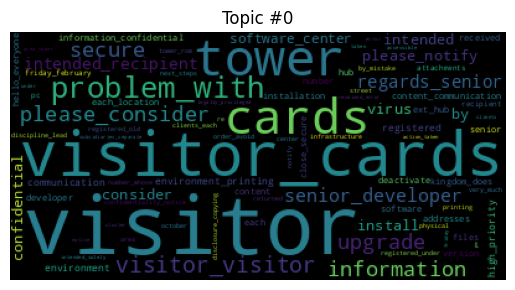

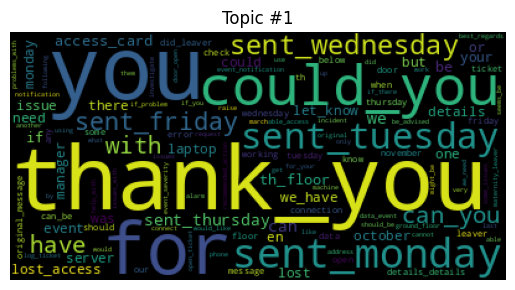

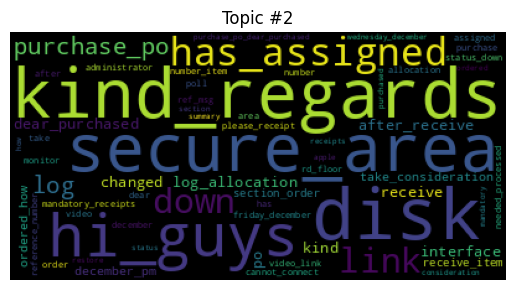

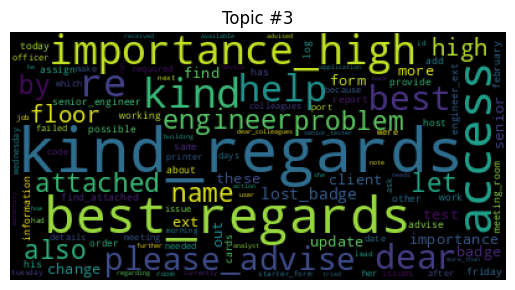

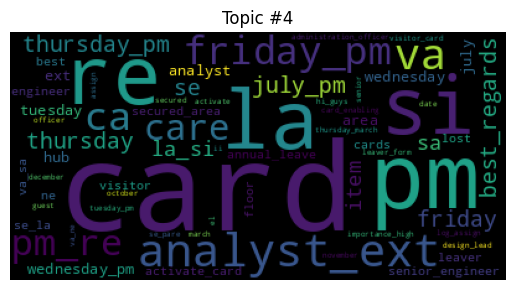

In [ ]:
for t in range(seeded_lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(seeded_lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
label_lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         eta=eta_label,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         eval_every = eval_every,
                         random_state=42,
                         per_word_topics=True)

In [ ]:
getLDAModelAccuracy(label_lda_model,corpus,data,"Label")

0.21433333333333332

In [ ]:
for num, params in label_lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.043*"visitor" + 0.029*"visitor_cards" + 0.018*"cards" + 0.018*"tower" + 0.016*"visitor_visitor" + 0.015*"please_consider" + 0.014*"secure" + 0.014*"upgrade" + 0.013*"senior_developer" + 0.013*"information"

1: 0.035*"thank_you" + 0.033*"you" + 0.021*"for" + 0.021*"could_you" + 0.020*"sent_monday" + 0.019*"sent_tuesday" + 0.018*"sent_wednesday" + 0.017*"sent_friday" + 0.017*"access" + 0.016*"with"

2: 0.041*"kind_regards" + 0.033*"secure_area" + 0.025*"has_assigned" + 0.020*"hi_guys" + 0.020*"down" + 0.019*"link" + 0.019*"purchase_po" + 0.017*"log" + 0.017*"kind" + 0.015*"log_allocation"

3: 0.032*"kind_regards" + 0.019*"best_regards" + 0.013*"kind" + 0.012*"re" + 0.012*"importance_high" + 0.009*"help" + 0.008*"dear" + 0.008*"best" + 0.008*"please_advise" + 0.007*"by"

4: 0.083*"card" + 0.035*"pm" + 0.032*"re" + 0.032*"la" + 0.029*"si" + 0.025*"analyst_ext" + 0.021*"va" + 0.017*"ca" + 0.017*"best_regards" + 0.017*"need"



In [ ]:
c_v_coherence_model_labellda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_model_labellda = c_v_coherence_model_labellda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_model_labellda)


C_V Coherence Score:  0.5138944402837256


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -4.462493924414275


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -4.329830037305486


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.11698023871111159


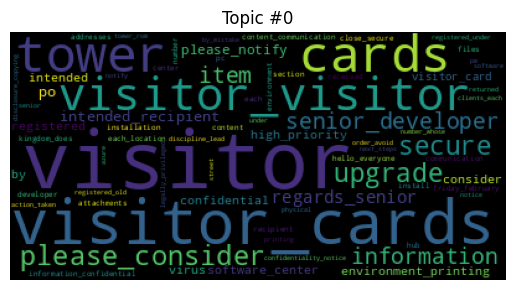

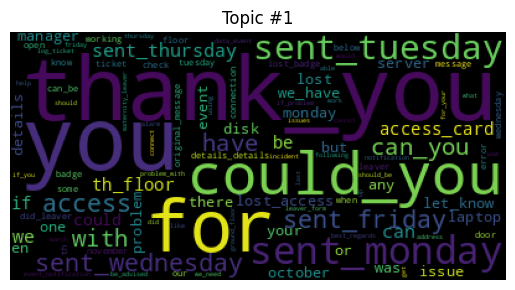

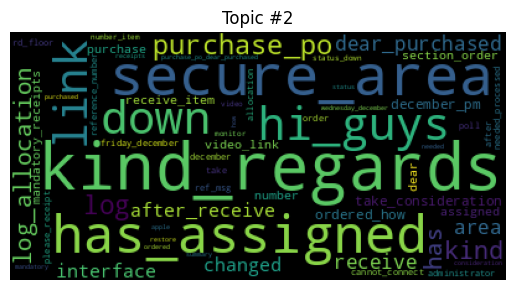

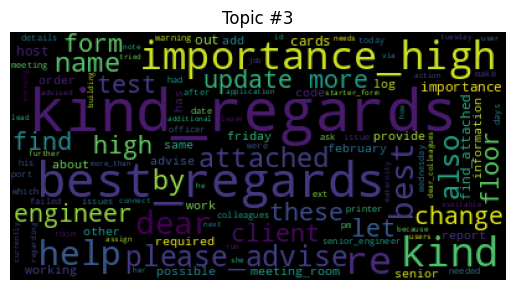

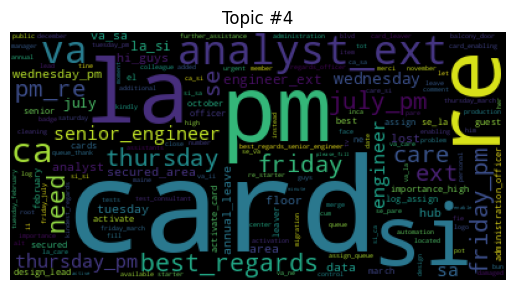

In [ ]:
for t in range(label_lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()